(48, 432)
(48, 432)
(48, 432)
(48, 432)
(48, 432)


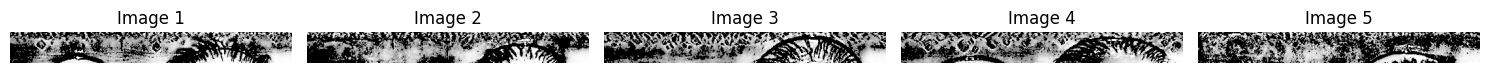

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

dataset_path = "/kaggle/input/iitd-normalized/Normalized_Images"
image_files = []

def load_and_display_images(dataset_path, num_images=5):


    global image_files
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.png', '.bmp', '.tiff')):  
                image_files.append(os.path.join(root, file))
    

    if len(image_files) < num_images:
        print(f"Only {len(image_files)} images found in the dataset.")
        num_images = len(image_files)
    

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img_path = image_files[i]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        print(img.shape)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Image {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


load_and_display_images(dataset_path)


In [2]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score


base_dir = "/kaggle/input/iitd-normalized/Normalized_Images"
data_dir = "/kaggle/working/Dataset"


os.makedirs(data_dir, exist_ok=True)



def split_data(base_dir, data_dir):
    for file_name in os.listdir(base_dir):
        folder_name = file_name.split("_")[0]
        folder_path = os.path.join(data_dir, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        shutil.copy(os.path.join(base_dir, file_name), os.path.join(folder_path, file_name))

split_data(base_dir, data_dir)



In [3]:

base_dir = "/kaggle/working/Dataset"
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


def split_data(base_dir, train_dir, test_dir):
    for person in os.listdir(base_dir):
        person_dir = os.path.join(base_dir, person)
        if os.path.isdir(person_dir):
                    images = [f for f in os.listdir(person_dir) if f.endswith('.bmp')]
                    print(images)
                    random.shuffle(images)
                    train_images = images[:4]
                    test_images = images[4:5]


                    train_eye_dir = os.path.join(train_dir, person)
                    os.makedirs(train_eye_dir, exist_ok=True)
                    for img in train_images:
                        shutil.copy(os.path.join(person_dir, img), os.path.join(train_eye_dir, img))

                    test_eye_dir = os.path.join(test_dir, person)
                    os.makedirs(test_eye_dir, exist_ok=True)
                    for img in test_images:
                        shutil.copy(os.path.join(person_dir, img), os.path.join(test_eye_dir, img))

split_data(base_dir, train_dir, test_dir)



['201_3.bmp', '201_5.bmp', '201_1.bmp', '201_4.bmp', '201_2.bmp']
['014_5.bmp', '014_1.bmp', '014_3.bmp', '014_2.bmp', '014_4.bmp']
['078_5.bmp', '078_3.bmp', '078_4.bmp', '078_2.bmp', '078_1.bmp']
['221_3.bmp', '221_2.bmp', '221_4.bmp', '221_1.bmp', '221_5.bmp']
['008_1.bmp', '008_4.bmp', '008_3.bmp', '008_2.bmp', '008_5.bmp']
['102_3.bmp', '102_2.bmp', '102_5.bmp', '102_4.bmp', '102_1.bmp']
['032_4.bmp', '032_5.bmp', '032_1.bmp', '032_2.bmp', '032_3.bmp']
['183_2.bmp', '183_5.bmp', '183_4.bmp', '183_1.bmp', '183_3.bmp']
['132_3.bmp', '132_1.bmp', '132_2.bmp', '132_5.bmp', '132_4.bmp']
['006_4.bmp', '006_1.bmp', '006_3.bmp', '006_2.bmp', '006_5.bmp']
['031_1.bmp', '031_2.bmp', '031_3.bmp', '031_5.bmp', '031_4.bmp']
['120_4.bmp', '120_1.bmp', '120_3.bmp', '120_5.bmp', '120_2.bmp']
['146_4.bmp', '146_3.bmp', '146_5.bmp', '146_2.bmp', '146_1.bmp']
['127_2.bmp', '127_5.bmp', '127_1.bmp', '127_4.bmp', '127_3.bmp']
['141_5.bmp', '141_4.bmp', '141_2.bmp', '141_3.bmp', '141_1.bmp']
['172_1.bm

In [4]:

def create_data_generator(directory, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    return generator

train_generator = create_data_generator(train_dir)
test_generator = create_data_generator(test_dir)


Found 896 images belonging to 224 classes.
Found 224 images belonging to 224 classes.


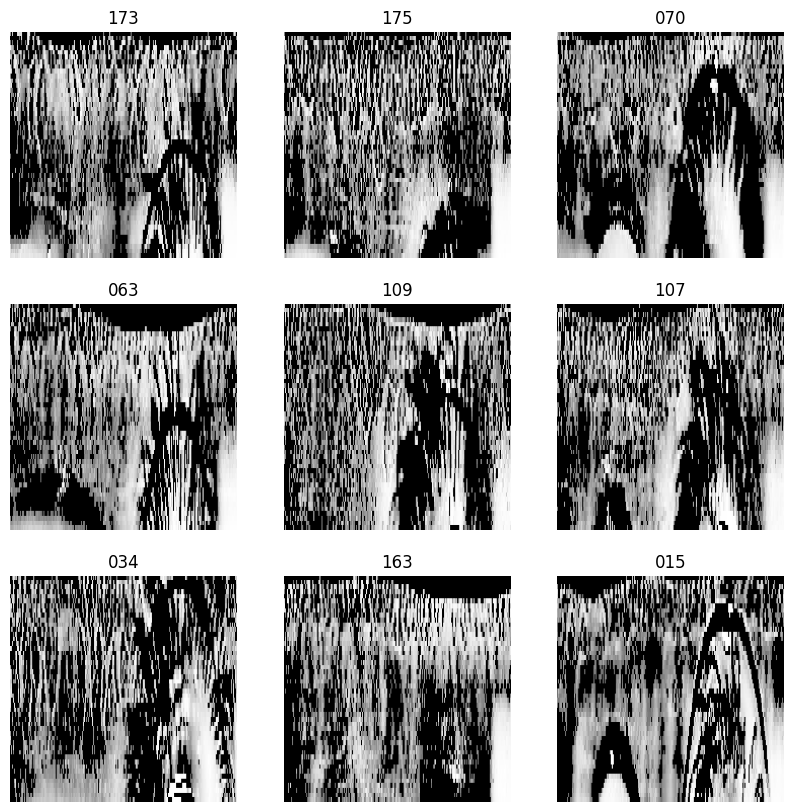

In [5]:

def view_images_from_generator(generator):
    class_indices = {v: k for k, v in generator.class_indices.items()}
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_label = class_indices[tf.argmax(labels[i]).numpy()]
        plt.title(class_label)
        plt.axis('off')
    plt.show()

view_images_from_generator(train_generator)

In [6]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)


for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



history = model.fit(train_generator, epochs=350, validation_data=test_generator)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/350


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.0026 - loss: 5.7416 - val_accuracy: 0.0045 - val_loss: 5.4036
Epoch 2/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0051 - loss: 5.4089 - val_accuracy: 0.0268 - val_loss: 5.3979
Epoch 3/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0047 - loss: 5.4019 - val_accuracy: 0.0045 - val_loss: 5.3913
Epoch 4/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0051 - loss: 5.3917 - val_accuracy: 0.0089 - val_loss: 5.3763
Epoch 5/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0081 - loss: 5.3734 - val_accuracy: 0.0179 - val_loss: 5.3505
Epoch 6/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0110 - loss: 5.3411 - val_accuracy: 0.0223 - val_loss: 5.3070
Epoch 7/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.0226 - loss: 5.2915 - val_accuracy: 0.0179 - val_loss: 5.2409
Epoch 8/350
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.0219 - loss: 5.2188 - val_accuracy: 0.0268 - val

In [7]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print("\nTest accuracy:", test_acc)


Test accuracy: 0.8482142686843872


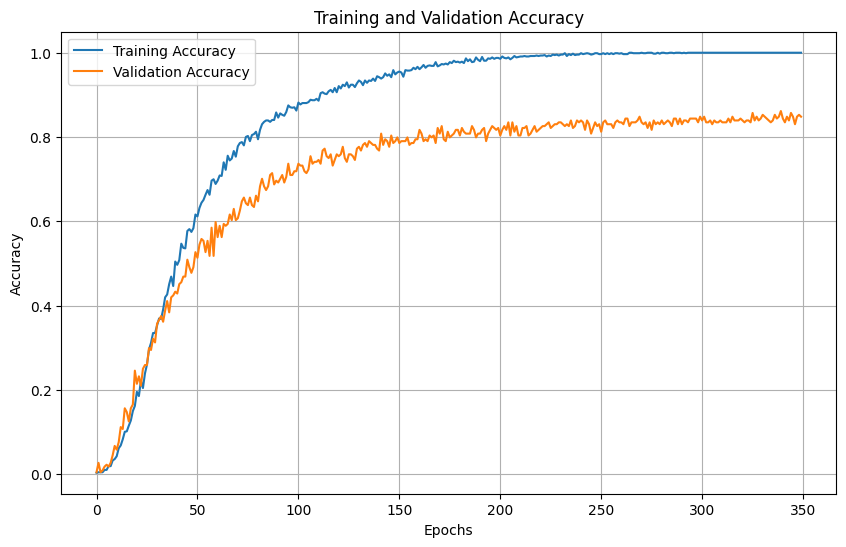

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy',)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


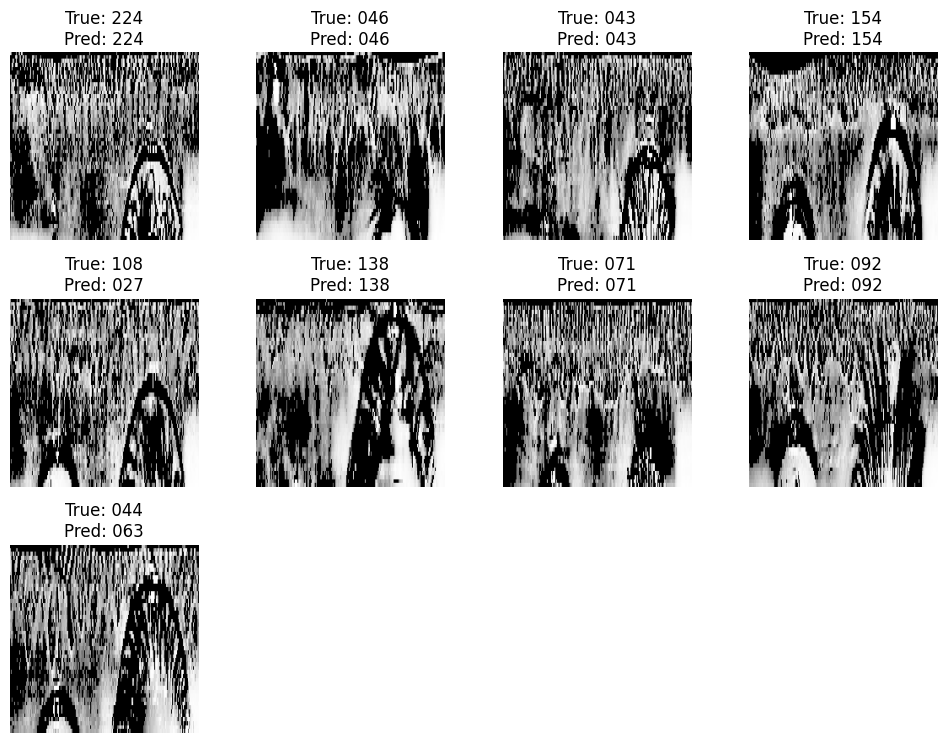

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_display(generator, model, class_names, num_images=5):
    images, true_labels = next(generator)
    
    images, true_labels = images[:num_images], true_labels[:num_images]
    
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        plt.subplot(int(num_images**(0.5)) + 1,int(num_images**(0.5))+1, i + 1)
        plt.imshow(images[i], cmap='gray' if images.shape[-1] == 1 else None)
        plt.axis('off')
        
        true_label = class_names[np.argmax(true_labels[i])]
        predicted_label = class_names[predicted_labels[i]]
        
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
    
    plt.tight_layout()
    plt.show()


class_names = list(train_generator.class_indices.keys())
predict_and_display(test_generator, model, class_names, num_images=9)
